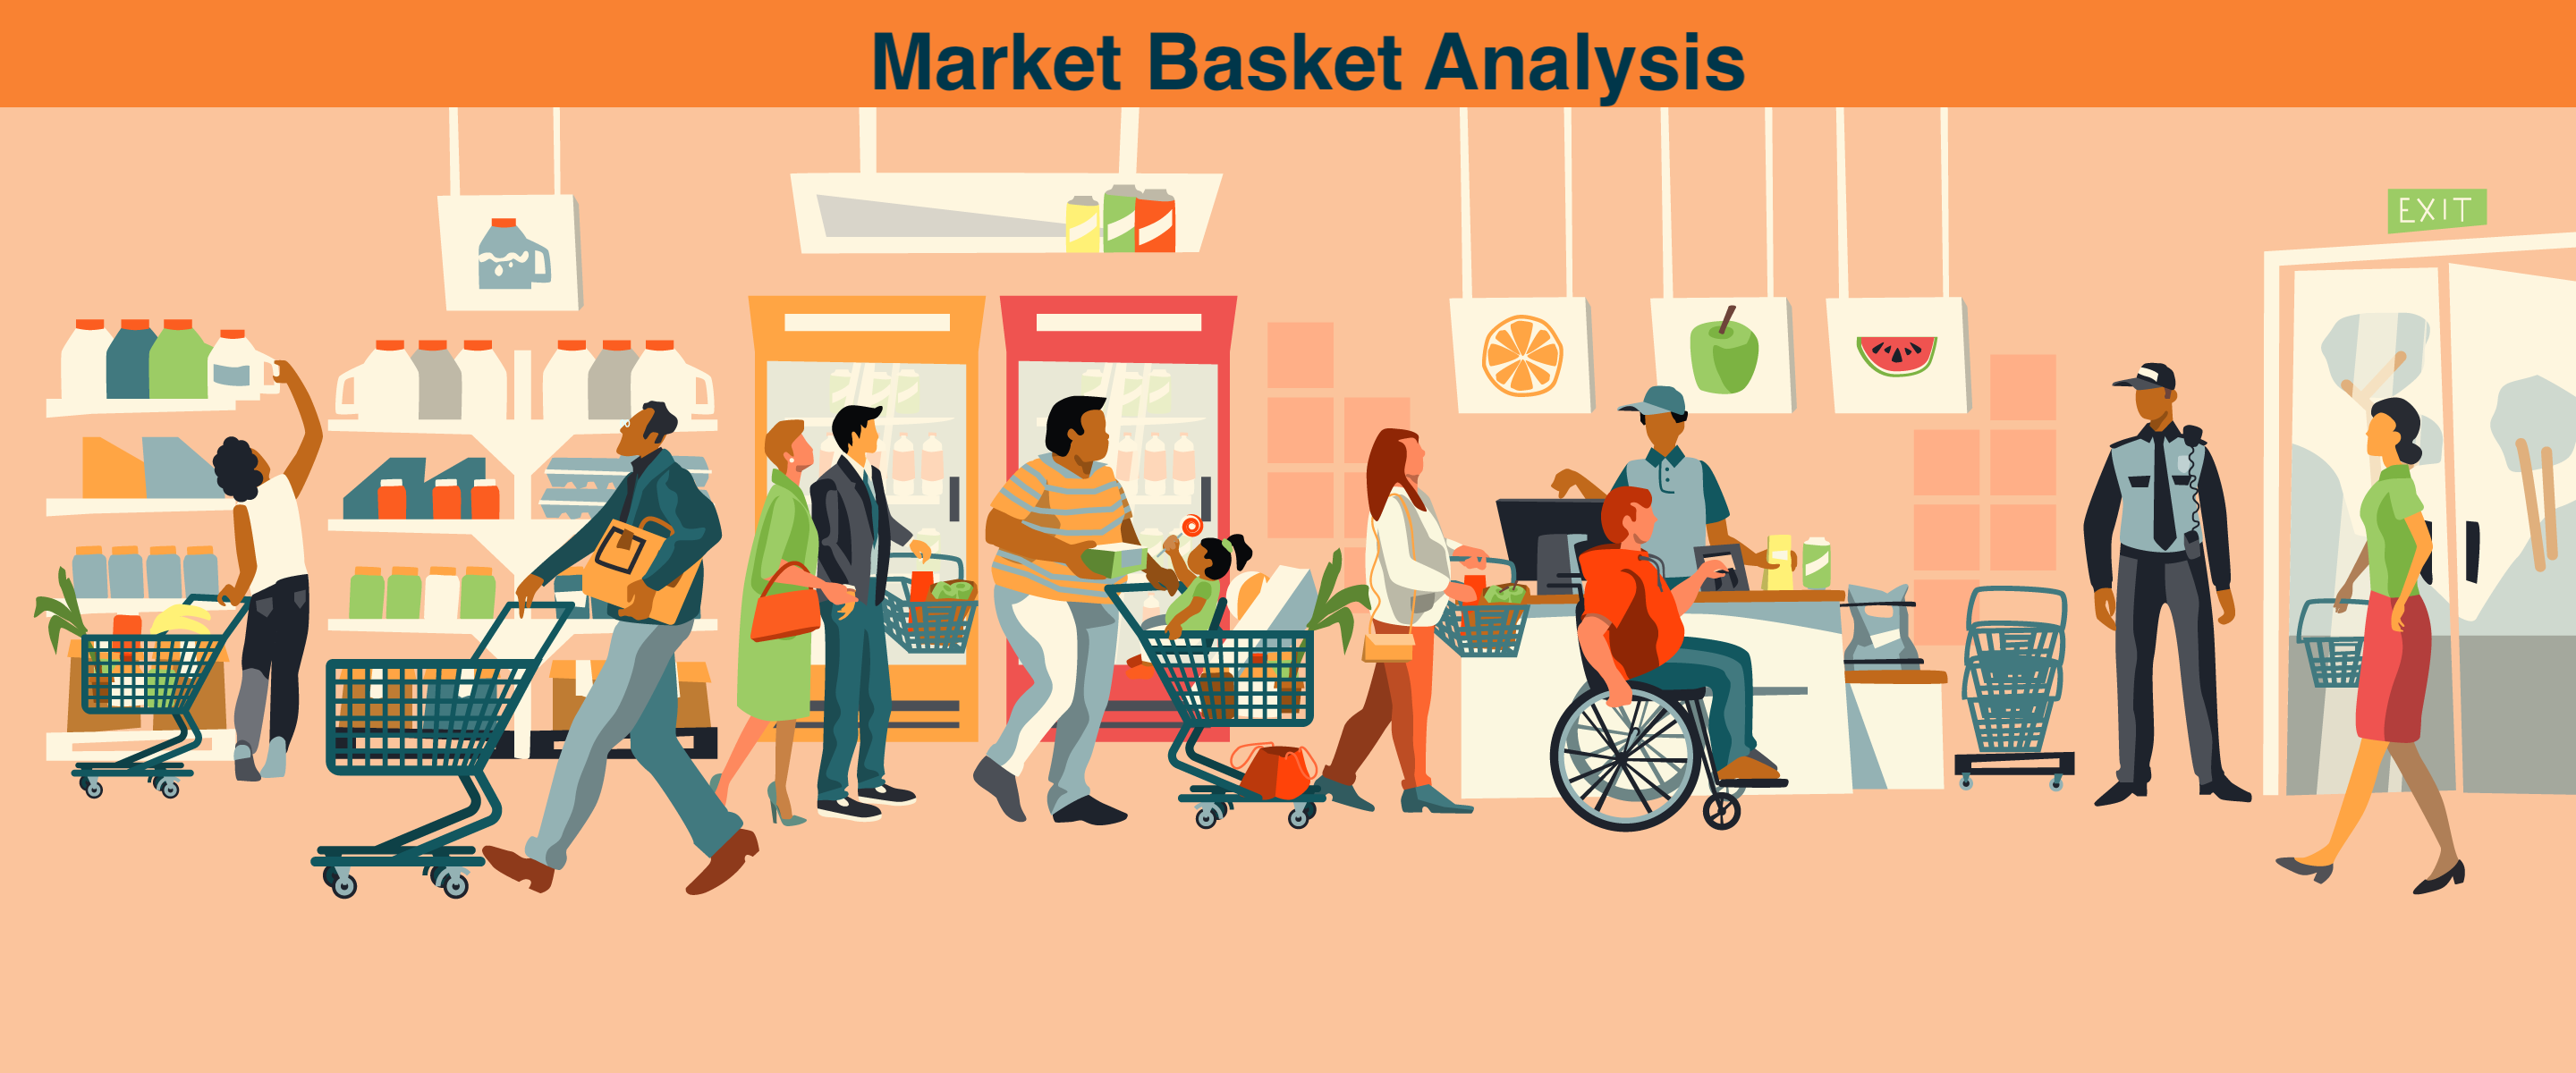

### Problem Stattement and method

Market basket analysis determines the products which are bought together and to reorganize the supermarket layout, and also to design promotional campaigns such that products' purchase can be improved. Hence, the Market consumer behaviors need to be analyzed, which can be done through different data mining techniques.

Association Rule Mining is used when you want to find an association between different objects in a set, find frequent patterns in a transaction database, relational databases or any other information repository. The applications of Association Rule Mining are found in Marketing, Basket Data Analysis (or Market Basket Analysis) in retailing, clustering and classification.

Apriori algorithm, a classic algorithm, is useful in mining frequent itemsets and relevant association rules. Usually, you operate this algorithm on a database containing a large number of transactions. One such example is the items customers buy at a supermarket.

_Method_ <br>

*Analyzing customers’ purchase habit <br>
*Which items are bought together frequently <br>
*Recommendation system for shopping websites<br>

_Dataset_ <br>

The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, we provide between 4 and 100 of their orders, with the sequence of products purchased in each order. We also provide the week and hour of day the order was placed, and a relative measure of time between orders. 

In [111]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from textwrap import wrap

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

**Import Data**

In [3]:
aisles = pd.read_csv(r'C:\Users\chath\Documents\DS\Final Capstone Project\Data\aisles.csv')
print(aisles.shape)
aisles.head()

(134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
departments = pd.read_csv(r'C:\Users\chath\Documents\DS\Final Capstone Project\Data\departments.csv')
print(departments.shape)
departments.head()52203


(21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [5]:
order_products_prior = pd.read_csv(r'C:\Users\chath\Documents\DS\Final Capstone Project\Data\order_products__prior.csv')
print(order_products_prior.shape)
order_products_prior.head()

(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [6]:
order_products_train = pd.read_csv(r'C:\Users\chath\Documents\DS\Final Capstone Project\Data\order_products__train.csv')
print(order_products_train.shape)
order_products_train.head()

(1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [7]:
orders = pd.read_csv(r'C:\Users\chath\Documents\DS\Final Capstone Project\Data\orders.csv')
print(orders.shape)
orders.head()

(3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [8]:
products = pd.read_csv(r'C:\Users\chath\Documents\DS\Final Capstone Project\Data\products.csv')
print(products.shape)
products.head()

(49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


#### Frequency of Orders by days of week

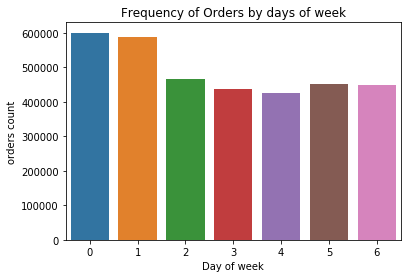

In [18]:
sns.countplot(x="order_dow",data = orders)
plt.xlabel("Day of week")
plt.ylabel("orders count")
plt.title("Frequency of Orders by days of week")
plt.show()

So mostly orders are placed in 0 and 1st day of the week. May be Saturday and Sunday.

#### Frequency of Orders by hours of the day

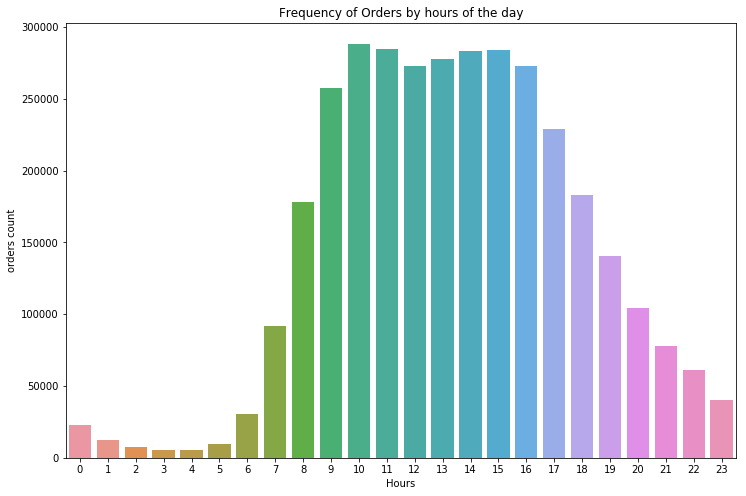

In [19]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day",data = orders)
plt.xlabel("Hours")
plt.ylabel("orders count")
plt.title("Frequency of Orders by hours of the day")
plt.show()

Majority of orders are made during day time and that also in the morning.Frequency of orders start decreasing after 16th hour.

#### Days since prior order

([<matplotlib.axis.XTick at 0x22843e7e8d0>,
 <a list of 31 Text xticklabel objects>)

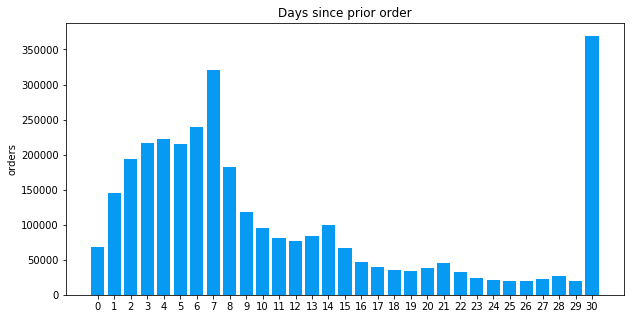

In [31]:
hour=orders['days_since_prior_order'].value_counts().sort_index()

plt.figure(figsize=(10,5))
plt.bar(hour.index,hour, color='xkcd:azure')
plt.title('Days since prior order')
plt.ylabel('orders')
plt.xticks(hour.index)

### Reorder percentage

In [49]:
#merging train and test data
order_products=pd.concat([order_products_train, order_products_prior])

In [50]:
print("The ratio of products reordered in order_products_prior: {}".format(order_products["reordered"].sum()/order_products.shape[0]))

The ratio of products reordered in order_products_prior: 0.5900617242809434


Text(0.5, 1.0, 'Reorder percentage')

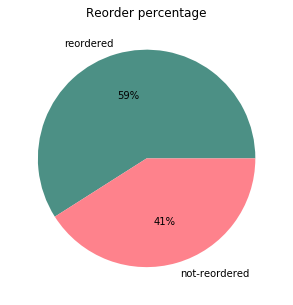

In [58]:
reorder=order_products['reordered'].value_counts()
colors=['xkcd:Dusty Teal','xkcd:Blush Pink']

plt.figure(figsize=(10,5))
plt.pie(reorder, labels=['reordered','not-reordered'],colors=colors, autopct='%1.0f%%')
plt.title('Reorder percentage')

59% of products are reordered!

In [52]:
order_products = pd.merge(order_products,products, on = 'product_id', how='left')
order_products = pd.merge(order_products,departments, on = "department_id", how="left")
order_products = pd.merge(order_products, aisles, on='aisle_id', how='left')

In [53]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,1,49302,1,1,Bulgarian Yogurt,120,16,dairy eggs,yogurt
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,dairy eggs,other creams cheeses
2,1,10246,3,0,Organic Celery Hearts,83,4,produce,fresh vegetables
3,1,49683,4,0,Cucumber Kirby,83,4,produce,fresh vegetables
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned goods,canned meat seafood


### Order count by department

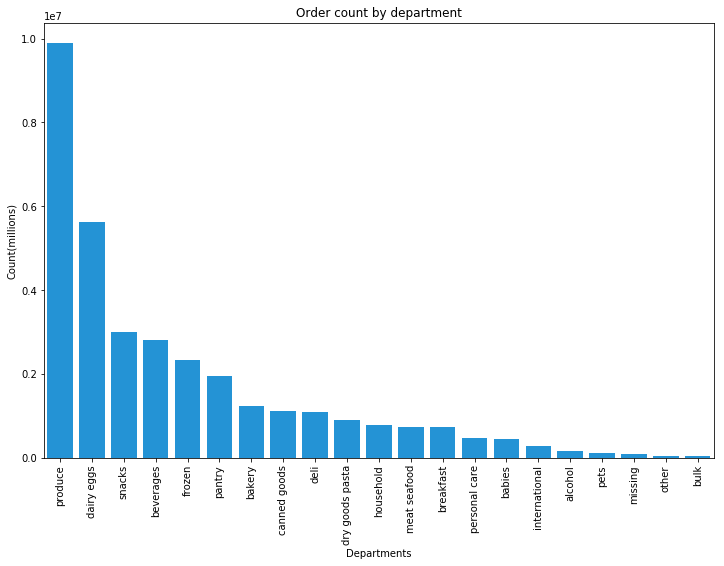

In [228]:
count = order_products["department"].value_counts()
plt.figure(figsize=(12,8))
sns.barplot(count.index,count.values ,color='xkcd:azure')
plt.xlabel("Departments")
plt.ylabel("Count(millions)")
plt.title("Order count by department")
plt.xticks(rotation="vertical")
plt.show()

### Order count by Aisle

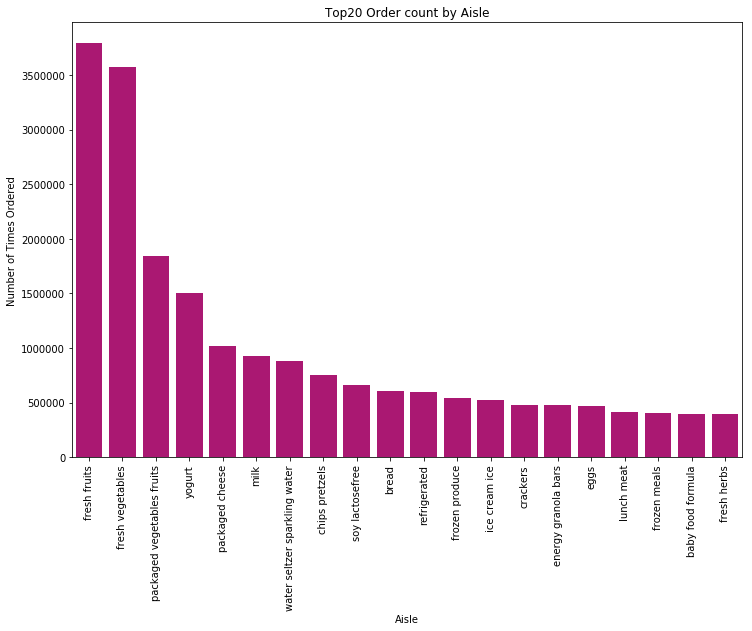

In [229]:
count = order_products["aisle"].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(count.index,count.values ,color='xkcd:magenta')
plt.xlabel("Aisle")
plt.ylabel("Number of Times Ordered")
plt.title("Top20 Order count by Aisle")
plt.xticks(rotation="vertical")
plt.show()

### Reorder ratio by department

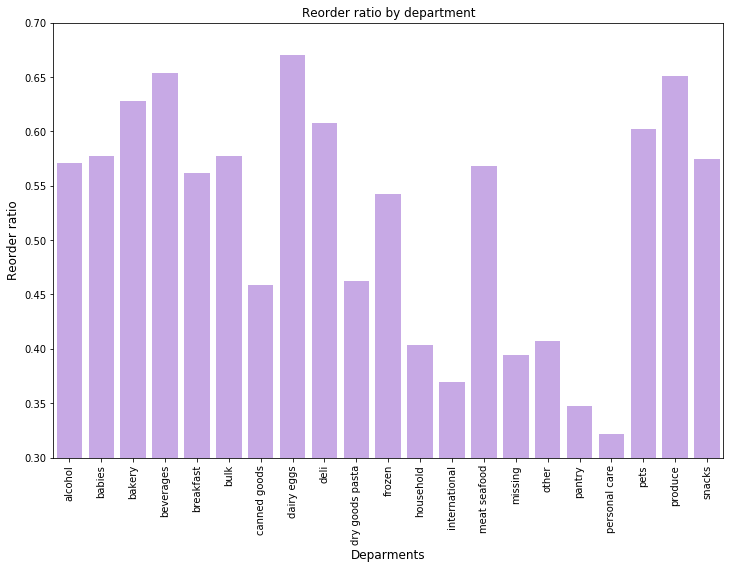

In [67]:
count = order_products.groupby("department")["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(count["department"].values, count["reordered"].values, color='xkcd:lavender' )
plt.xticks(rotation = "vertical")
plt.xlabel("Deparments", fontsize=12)
plt.ylabel("Reorder ratio", fontsize=12)
plt.title("Reorder ratio by department")
plt.ylim(0.3,0.7)
plt.show()

### Most Populer Items

In [78]:
Top20=order_products['product_name'].value_counts().head(20).reset_index()
Top20.columns=['product','count']
Top20.head()

,product,count
0,Banana,491291
1,Bag of Organic Bananas,394930
2,Organic Strawberries,275577
3,Organic Baby Spinach,251705
4,Organic Hass Avocado,220877


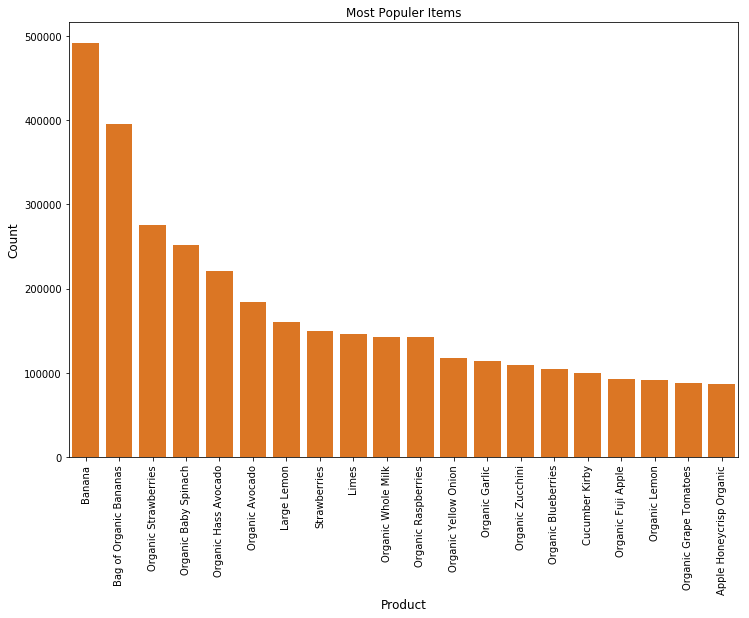

In [83]:
plt.figure(figsize=(12,8))
sns.barplot(Top20["product"].values, Top20["count"].values, color='xkcd:orange' )
plt.xticks(rotation = "vertical")
plt.xlabel("Product", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Most Populer Items")
plt.show()

# Data Preprocessing

In [90]:
# Obtain new dataframe with only reordered products

reorder_products=order_products[order_products['reordered']==1]
print(reorder_products.shape)

(19955360, 9)


Due to huge number of data, select a random sample of 40000 to move forward

In [150]:
reorder_prod_smpl=reorder_products[reorder_products['order_id']<=40000]
print(reorder_prod_smpl.shape)

(233123, 9)


In [151]:
# Obtaining unique order data
order_unique =reorder_prod_smpl['order_id'].unique()
order_unique.size

34487

In [152]:
# Data transformation for mlxtend toolbox
transaction=[]
for order in order_unique:
    temp_df=reorder_prod_smpl[reorder_prod_smpl['order_id']==order]['product_name'].to_list()
    transaction.append(temp_df)

In [153]:
# Using Transaction encoder

tra_enc = TransactionEncoder()
tra_enc_ary = tra_enc.fit(transaction).transform(transaction)
tra_enc_data = pd.DataFrame(tra_enc_ary, columns=tra_enc.columns_)
tra_enc_data.head()

,#2 Coffee Filters,#4 Natural Brown Coffee Filters,& Go! Hazelnut Spread + Pretzel Sticks,0 Calorie Acai Raspberry Water Beverage,0% Fat Black Cherry Greek Yogurt y,0% Fat Blueberry Greek Yogurt,0% Fat Free Organic Milk,0% Fat Greek Yogurt Black Cherry on the Bottom,0% Fat Greek Yogurt Vanilla,0% Fat Organic Greek Vanilla Yogurt,...,vitaminwater® XXX Acai Blueberry Pomegranate,with Bleach Powder Cleanser,with Crispy Almonds Cereal,with Olive Oil Mayonnaise,with Olive Oil Mayonnaise Dressing,with Seasoned Roasted Potatoes Scrambled Eggs & Sausage,with Sweet & Smoky BBQ Sauce Cheeseburger Sliders,with Xylitol Cinnamon 18 Sticks Sugar Free Gum,with Xylitol Minty Sweet Twist 18 Sticks Sugar Free Gum,with a Splash of Mango Coconut Water
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [154]:
tra_enc_data.shape

(34487, 19210)

# Apriori Algorithm

A key concept in Apriori algorithm is the anti-monotonicity of the support measure. It assumes that

* All subsets of a frequent itemset must be frequent
* Similarly, for any infrequent itemset, all its supersets must be infrequent too

**Step 1**: Create a frequency table of all the items that occur in all the transactions.

**Step 2**: We know that only those elements are significant for which the support is greater than or equal to the threshold support.

**Step 3**: The next step is to make all the possible pairs of the significant items keeping in mind that the order doesn’t matter, i.e., AB is same as BA.

**Step 4**: We will now count the occurrences of each pair in all the transactions.

**Step 5**: Again only those itemsets are significant which cross the support threshold

**Step 6**: Now let’s say we would like to look for a set of three items that are purchased together. We will use the itemsets found in step 5 and create a set of 3 items.

Since the number of items is huge, minimum support value was set as 0.005 in order to include most of item sets in analysis


In [179]:
frequent_itemsets = apriori(tra_enc_data, min_support = 0.005, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets=frequent_itemsets.sort_values(by=['support'],ascending=False)
frequent_itemsets.head()

,support,itemsets,length
7,0.141851,(Banana),1
6,0.113869,(Bag of Organic Bananas),1
106,0.071273,(Organic Strawberries),1
53,0.066808,(Organic Baby Spinach),1
78,0.059994,(Organic Hass Avocado),1


In [180]:
frequent_itemsets.shape

(198, 3)

In [192]:
# if lift value is 1, two items are independent

association=association_rules(frequent_itemsets, metric="lift", min_threshold=1)
association['ante_length'] = association['antecedents'].apply(lambda x: len(x))
association['cons_length'] = association['consequents'].apply(lambda x: len(x))
association=association.sort_values(by='lift',ascending=False)
association.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,ante_length,cons_length
53,(Limes),(Large Lemon),0.032882,0.036593,0.006263,0.190476,5.205192,0.005060,1.190090,1,1
52,(Large Lemon),(Limes),0.036593,0.032882,0.006263,0.171157,5.205192,0.005060,1.166829,1,1
59,(Organic Lemon),(Organic Hass Avocado),0.023023,0.059994,0.005973,0.259446,4.324557,0.004592,1.269328,1,1
58,(Organic Hass Avocado),(Organic Lemon),0.059994,0.023023,0.005973,0.099565,4.324557,0.004592,1.085005,1,1
48,(Organic Avocado),(Large Lemon),0.047612,0.036593,0.006350,0.133374,3.644744,0.004608,1.111675,1,1


In [193]:
# replace frozenset to string
lift=association.copy()
lift['antecedents']=lift['antecedents'].apply(lambda x: ', '.join(list(x))).astype("unicode")
lift['consequents']=lift['consequents'].apply(lambda x: ', '.join(list(x))).astype("unicode")

In [194]:
# make a new column including sorted list of ant and cons
lift['pair']=lift.apply(lambda row: ', '.join(sorted([row.antecedents,row.consequents])), axis=1)

In [210]:
df=lift[lift['ante_length']==1].drop_duplicates(subset='pair',keep='first').head(20)

In [211]:
df.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,ante_length,cons_length,pair
53,Limes,Large Lemon,0.032882,0.036593,0.006263,0.190476,5.205192,0.005060,1.190090,1,1,"Large Lemon, Limes"
59,Organic Lemon,Organic Hass Avocado,0.023023,0.059994,0.005973,0.259446,4.324557,0.004592,1.269328,1,1,"Organic Hass Avocado, Organic Lemon"
48,Organic Avocado,Large Lemon,0.047612,0.036593,0.006350,0.133374,3.644744,0.004608,1.111675,1,1,"Large Lemon, Organic Avocado"
65,Limes,Organic Avocado,0.032882,0.047612,0.005654,0.171958,3.611635,0.004089,1.150168,1,1,"Limes, Organic Avocado"
24,Organic Raspberries,Organic Strawberries,0.038188,0.071273,0.008641,0.226272,3.174710,0.005919,1.200327,1,1,"Organic Raspberries, Organic Strawberries"


### Top20 item pairs by lift metric

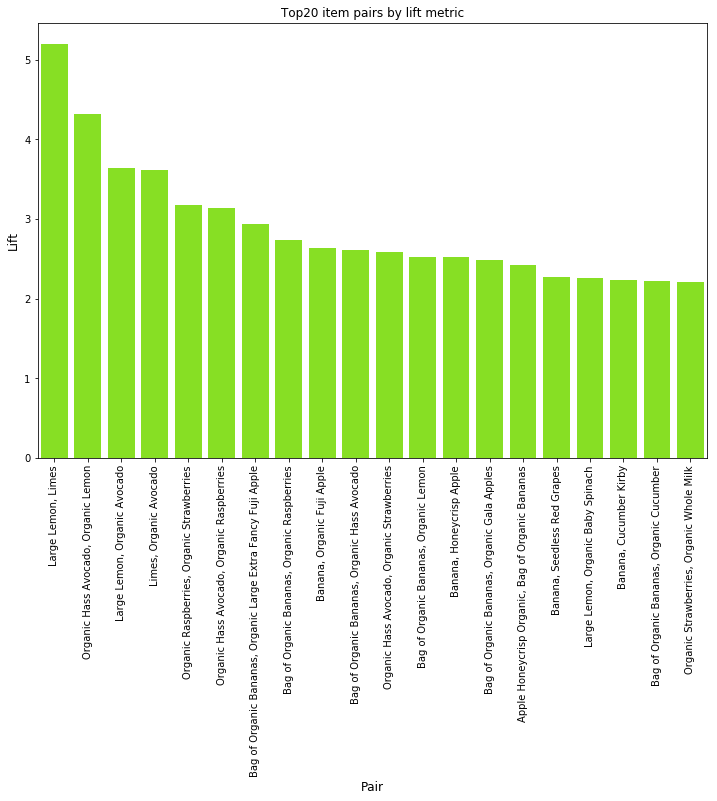

In [212]:
plt.figure(figsize=(12,8))
sns.barplot(df["pair"].values, df["lift"].values, color='xkcd:lime green' )
plt.xticks(rotation = "vertical")
plt.xlabel("Pair", fontsize=12)
plt.ylabel("Lift", fontsize=12)
plt.title("Top20 item pairs by lift metric")
plt.show()

### Top 20 Lift Items with relationship

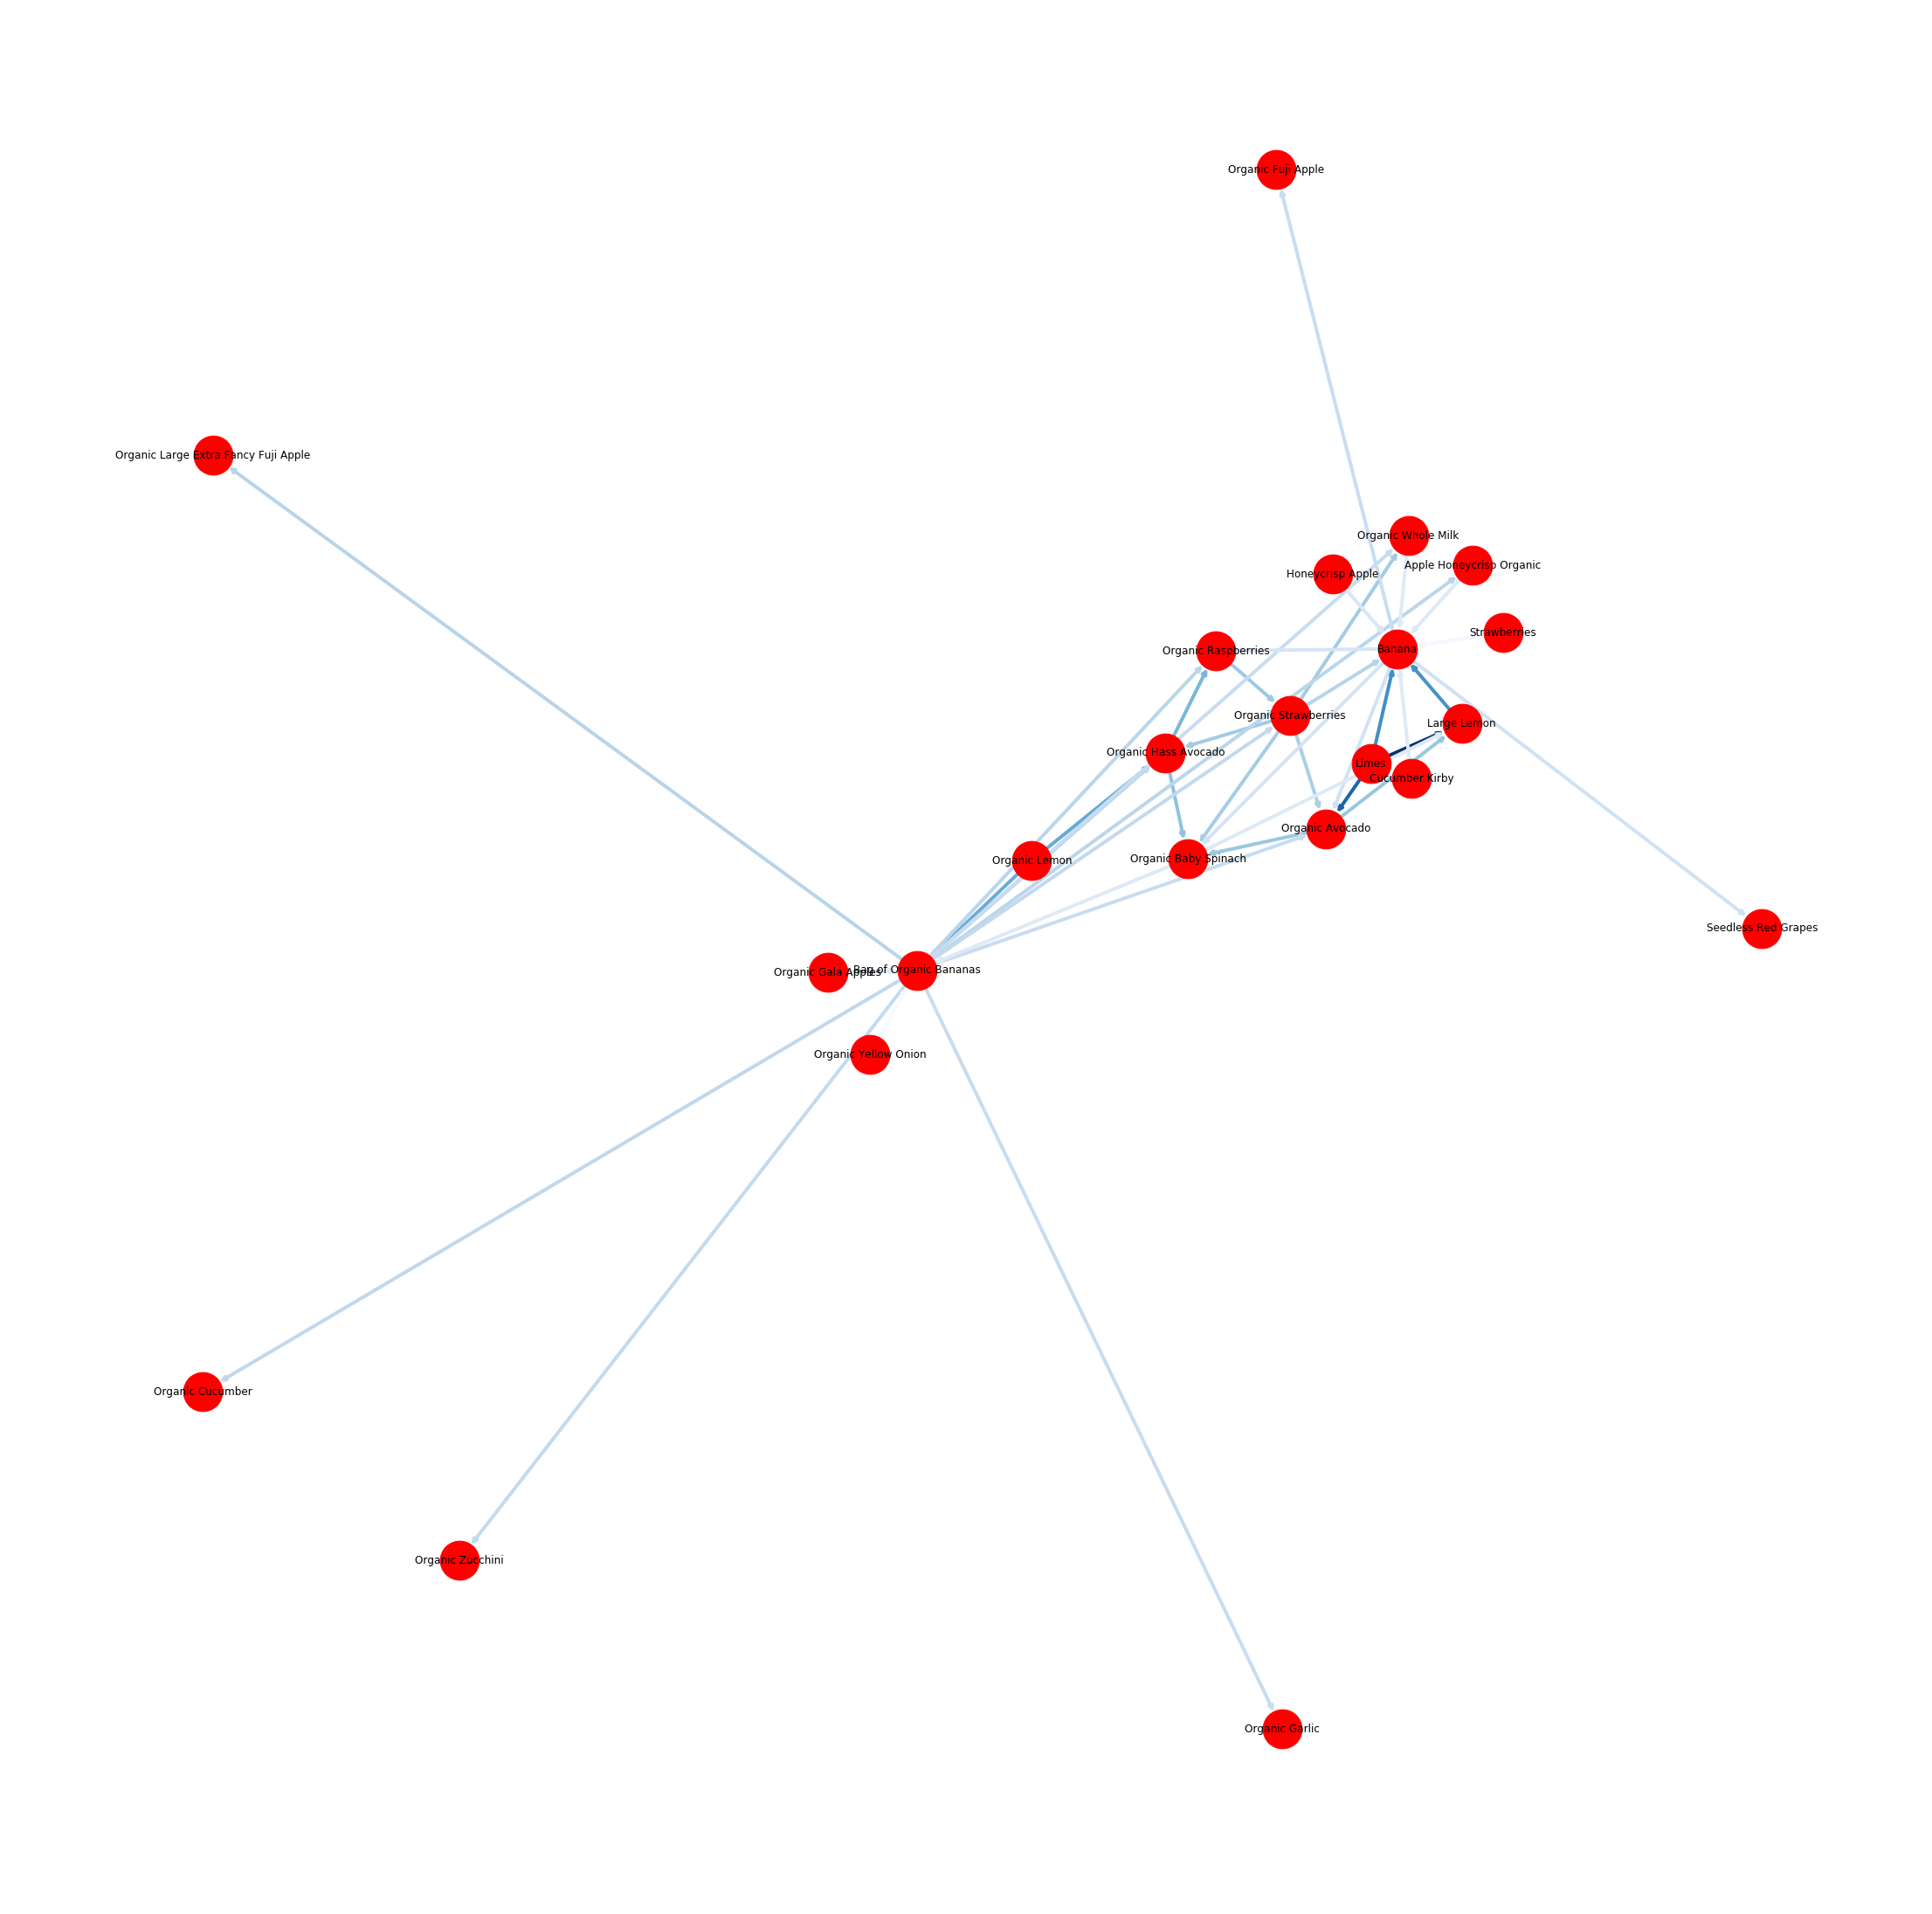

In [245]:
# Build a dataframe with your connections
df=df[['antecedents','consequents','lift','confidence','pair']]


# Build your graph. Note that we use the DiGraph function to create the graph!
G=nx.from_pandas_edgelist(df, 'antecedents', 'consequents', create_using=nx.DiGraph() )
 
# Make the graph
plt.figure(figsize=(30,30))
nx.draw(G, with_labels=True,node_size=2000, node_color='#FF0000',alpha=1, edge_color=df['lift'].to_list(),width=4, edge_cmap=plt.cm.Blues)


### Top 20 lift items and their relationships by departments

In [246]:
df=lift[(lift['ante_length']==1) & (lift['cons_length']==1)].drop_duplicates(subset='pair',keep='first')
df.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,ante_length,cons_length,pair
53,Limes,Large Lemon,0.032882,0.036593,0.006263,0.190476,5.205192,0.005060,1.190090,1,1,"Large Lemon, Limes"
59,Organic Lemon,Organic Hass Avocado,0.023023,0.059994,0.005973,0.259446,4.324557,0.004592,1.269328,1,1,"Organic Hass Avocado, Organic Lemon"
48,Organic Avocado,Large Lemon,0.047612,0.036593,0.006350,0.133374,3.644744,0.004608,1.111675,1,1,"Large Lemon, Organic Avocado"
65,Limes,Organic Avocado,0.032882,0.047612,0.005654,0.171958,3.611635,0.004089,1.150168,1,1,"Limes, Organic Avocado"
24,Organic Raspberries,Organic Strawberries,0.038188,0.071273,0.008641,0.226272,3.174710,0.005919,1.200327,1,1,"Organic Raspberries, Organic Strawberries"


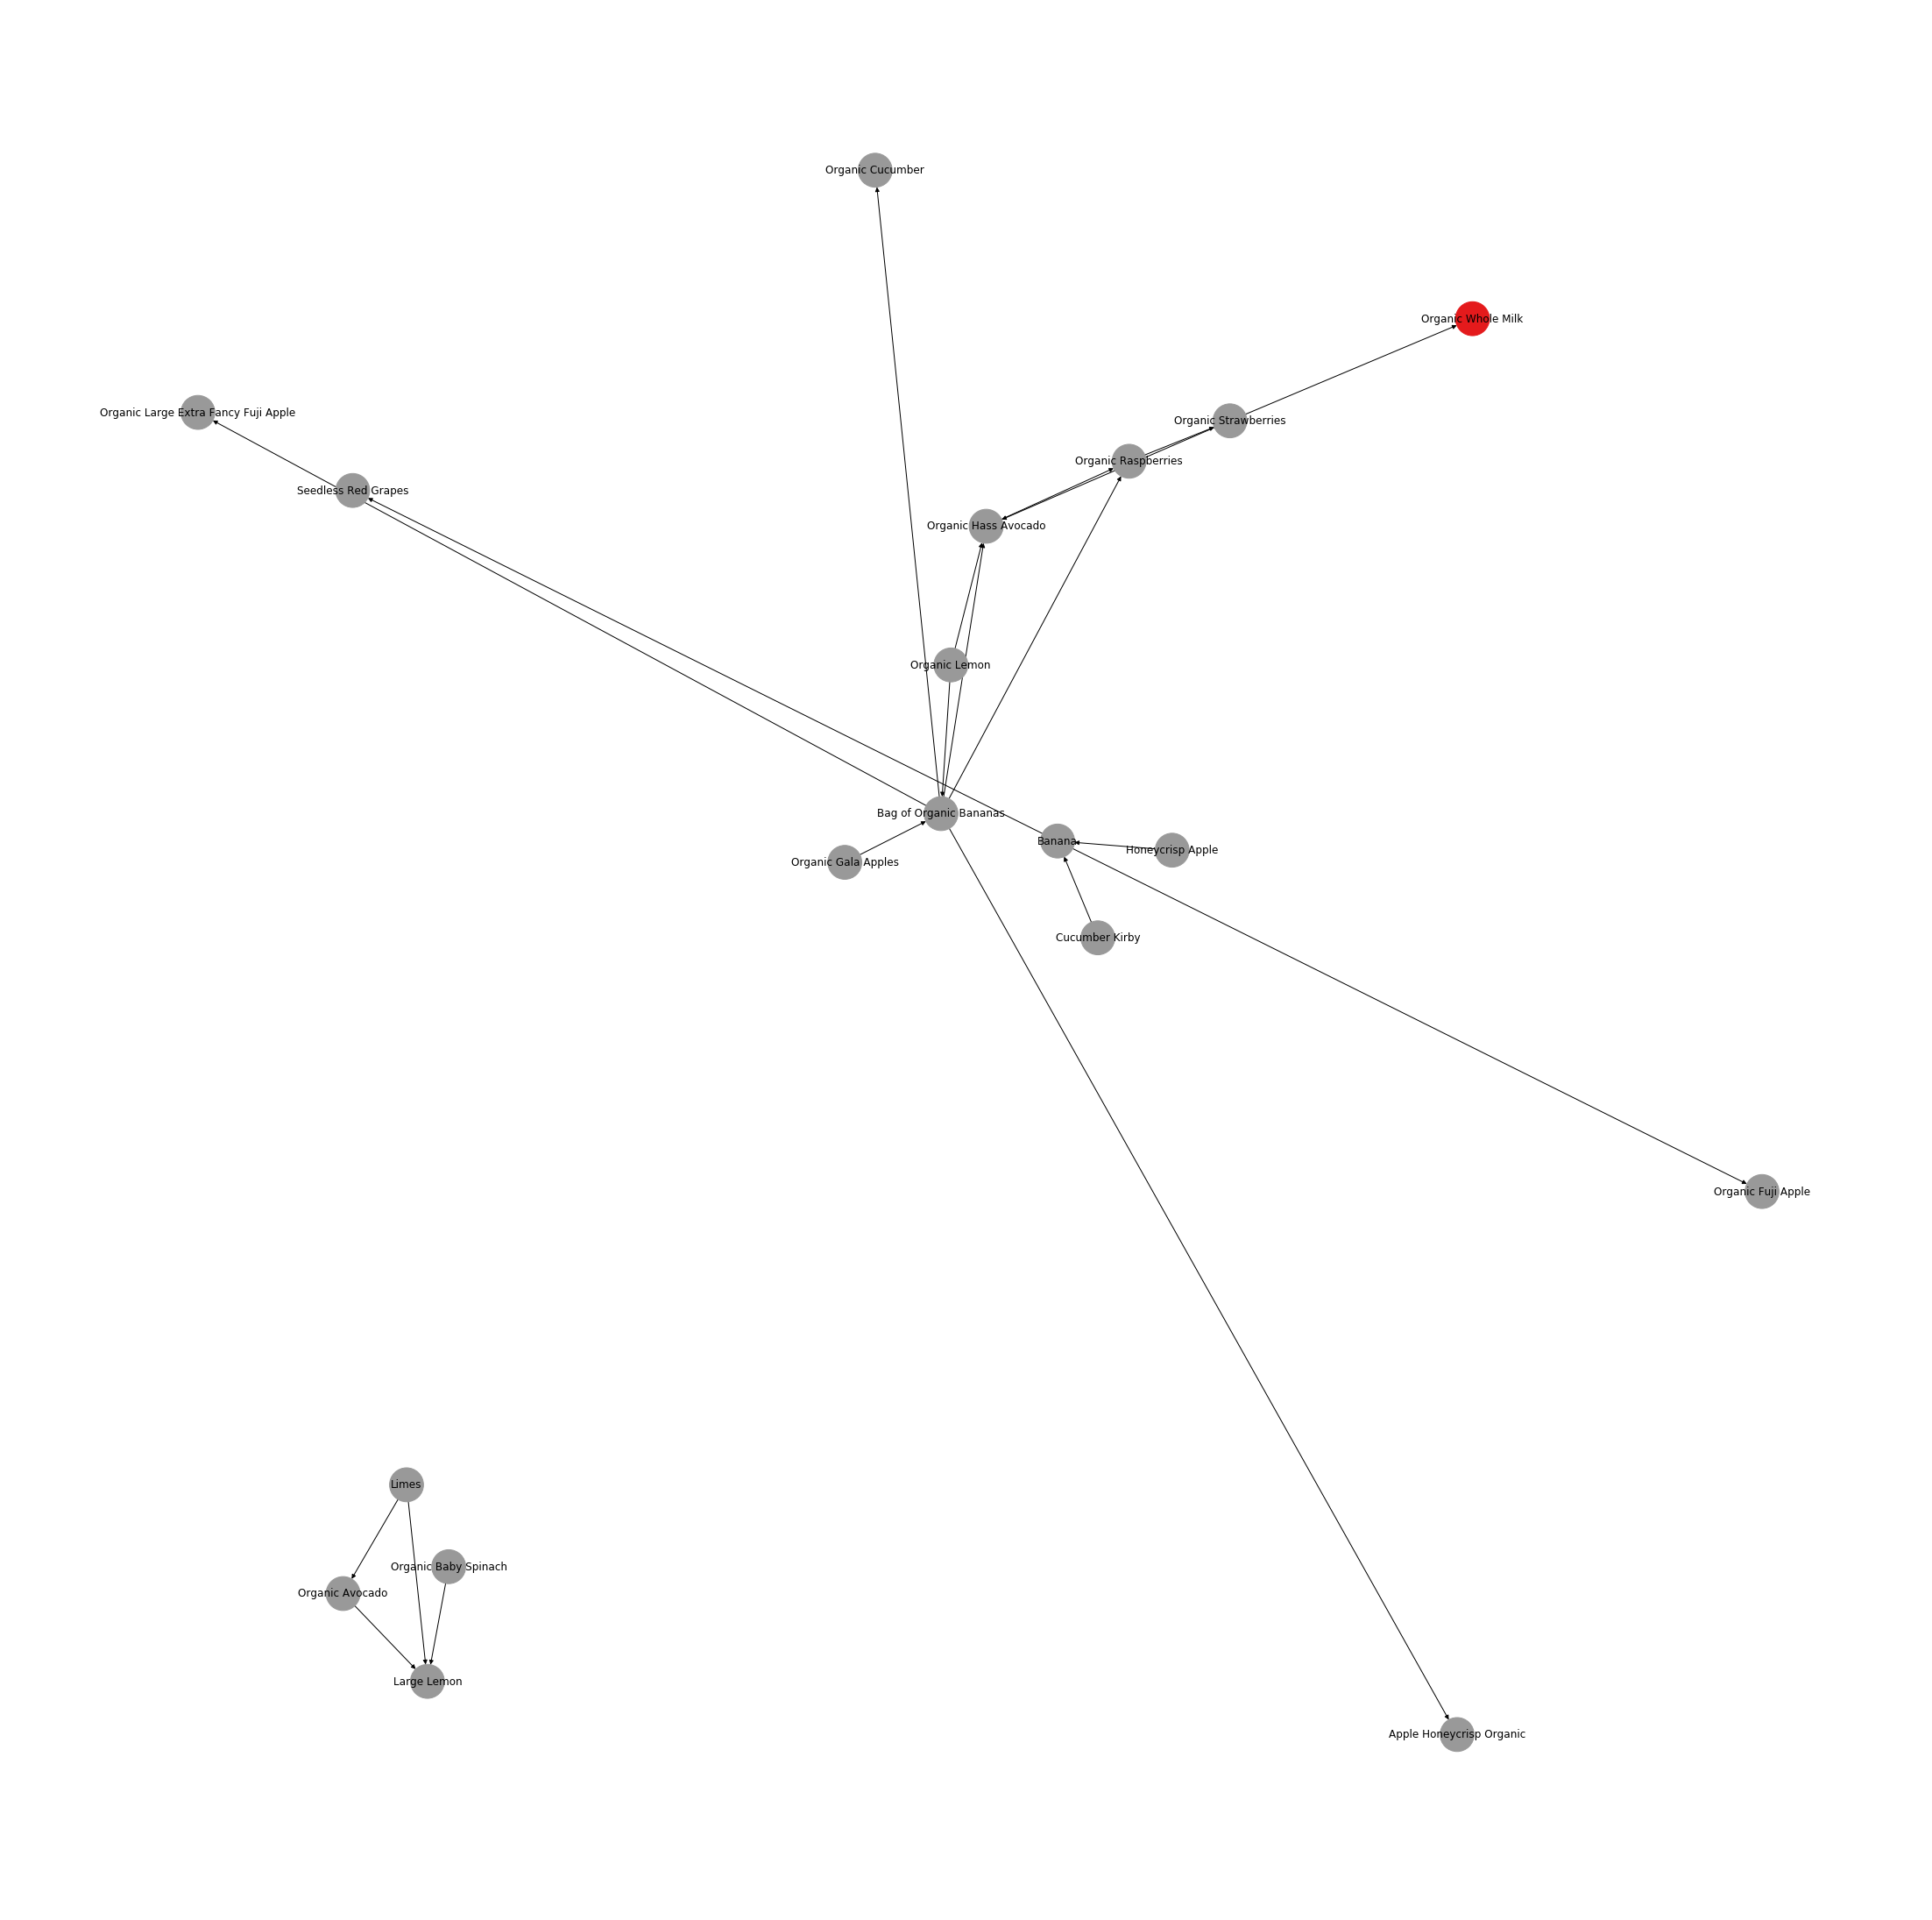

In [247]:
# Build a dataframe with connections
df=df[['antecedents','consequents','lift','confidence','pair']]

# merging all the product info with aisle and deparment
product_info=products.merge(aisles,on='aisle_id').merge(departments,on='department_id')

# Add a data frame with characteristics of nodes
carac = product_info[['product_name','department']] 

# Build the graph
G=nx.from_pandas_edgelist(df2, 'antecedents', 'consequents', create_using=nx.DiGraph() )
 
# The order of the node for networkX is the following order:
G.nodes()
 
# Reorder carac to assign the good color to each node
carac= carac.set_index('product_name')
carac=carac.reindex(G.nodes())
 
# And I need to transform my categorical column in a numerical value: group1->1, group2->2...
carac['myvalue']=pd.Categorical(carac['department'])
carac['myvalue'].cat.codes
 
# Custom the nodes:
plt.figure(figsize=(30,30))
nx.draw(G, with_labels=True, node_color=carac['myvalue'].cat.codes, cmap=plt.cm.Set1, node_size=1500)